In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
myresults=pd.read_pickle('data/match_predictions.pkl')

In [7]:
myresults=myresults.reset_index(drop=True)

In [8]:
myresults

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
0,2023-08-04,Sheffield Weds,Southampton,A,season23,3.10,3.4,2.30,3.31,3.14,3.47,3.38,2.35,2.28,A,0.382851,0.228971,0.388178
1,2023-08-05,Blackburn,West Brom,H,season23,2.75,3.3,2.60,2.92,2.78,3.30,3.21,2.72,2.62,H,0.370586,0.286758,0.342655
2,2023-08-05,Bristol City,Preston,D,season23,2.05,3.5,3.60,2.15,2.08,3.50,3.39,3.72,3.63,H,0.459704,0.287815,0.252481
3,2023-08-05,Middlesbrough,Millwall,A,season23,1.91,3.3,4.33,2.05,1.95,3.60,3.47,4.33,3.97,H,0.466858,0.316061,0.217081
4,2023-08-05,Norwich,Hull,H,season23,1.75,3.5,5.00,1.82,1.77,3.75,3.65,5.00,4.65,H,0.547513,0.264961,0.187526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,2024-05-04,Rotherham,Cardiff,H,season23,3.40,3.4,2.20,3.50,3.40,3.45,3.35,2.23,2.16,A,0.313730,0.243821,0.442449
548,2024-05-04,Stoke,Bristol City,H,season23,2.05,3.4,3.75,2.10,2.05,3.70,3.52,3.75,3.51,H,0.430321,0.281037,0.288642
549,2024-05-04,Sunderland,Sheffield Weds,A,season23,2.70,3.4,2.55,2.87,2.73,3.40,3.25,2.80,2.62,D,0.299973,0.352832,0.347195
550,2024-05-04,Swansea,Millwall,A,season23,2.05,3.5,3.60,2.07,2.04,3.61,3.50,3.76,3.57,H,0.432750,0.287685,0.279565


I will focus on comparing my probablities to bet365's for now. I will drop the other betting columns

In [9]:
myresults.drop(columns=['MaxH', 'AvgH' , 'MaxD', 'AvgD', 'MaxA', 'AvgA'], inplace=True)

I will convert the bet365 columns into implied probability and then compare to my probabilities

In [10]:
myresults[['B365H_implied', 'B365D_implied', 'B365A_implied']]=1/myresults[['B365H', 'B365D', 'B365A']]

In [11]:
myresults['B365_total_implied']=myresults[['B365H_implied', 'B365D_implied', 'B365A_implied']].sum(axis=1)

In [13]:
myresults['B365_total_implied'].mean()

1.0537161790794443

In [14]:
# Define a mapping from column names to results
column_to_result = {
    'B365H_implied': 'H',
    'B365D_implied': 'D',
    'B365A_implied': 'A'
}

# Find the column with the maximum value and map it to 'H', 'D', or 'A'
myresults['B365_prediction'] = myresults[['B365H_implied', 'B365D_implied', 'B365A_implied']].idxmax(axis=1).map(column_to_result)

In [17]:
# Create the 'betWinnings' column
myresults['betWinnings'] = np.where(
    myresults['predictions'] == myresults['FTR'],  # Check if the prediction matches the actual result
    myresults.apply(
        lambda row: 10 * row[f"B365{row['FTR']}"], axis=1  # Multiply by the corresponding odds column
    ),
    0  # If prediction is incorrect, winnings are 0
)

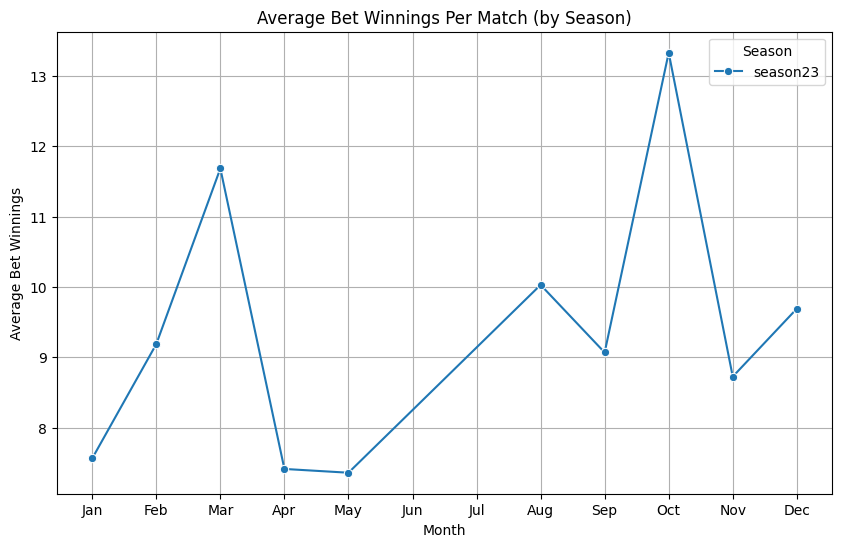

In [19]:
grouped = (
    myresults.groupby(['season', myresults['Date'].dt.month.rename('Month')])['betWinnings']
    .mean()
    .reset_index(name='AverageBetWinnings')
)



# Step 2: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='Month', y='AverageBetWinnings', hue='season', marker='o')

# Customizing the plot
plt.title('Average Bet Winnings Per Match (by Season)')
plt.xlabel('Month')
plt.ylabel('Average Bet Winnings')
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Season')
plt.grid()

plt.show()

In [20]:
myresults.groupby(myresults['Date'].dt.to_period('M'))['betWinnings'].mean()

Date
2023-08    10.029167
2023-09     9.067797
2023-10    13.330000
2023-11     8.724490
2023-12     9.690476
2024-01     7.562791
2024-02     9.187500
2024-03    11.684483
2024-04     7.412000
2024-05     7.358333
Freq: M, Name: betWinnings, dtype: float64

In [21]:
myresults['betWinnings'].sum()

5292.8

In [25]:
myresults[
    ((myresults['predictions'] == 'H') & (myresults['B365_prediction'] == 'A')) |
    ((myresults['predictions'] == 'A') & (myresults['B365_prediction'] == 'H'))
]['betWinnings'].sum()

513.5

In [26]:
len(myresults[
    ((myresults['predictions'] == 'H') & (myresults['B365_prediction'] == 'A')) |
    ((myresults['predictions'] == 'A') & (myresults['B365_prediction'] == 'H'))
]['betWinnings'])

44

In [27]:
myresults[
    ((myresults['predictions'] == 'D')  |(myresults['B365_prediction'] == 'D'))
]['betWinnings'].sum()

137.5

In [28]:
len(myresults[
    ((myresults['predictions'] == 'D')  |(myresults['B365_prediction'] == 'D'))
]['betWinnings'])

10

Should I bet on a draw when my odds differ with bet365?

In [30]:
# Create the 'betWinningsDraw' column
myresults['betWinningsDraw'] = np.where(
    'D' == myresults['FTR'],  # Check if the prediction matches the actual result
    myresults.apply(
        lambda row: 10 * row[f"B365{row['FTR']}"], axis=1  # Multiply by the corresponding odds column
    ),
    0  # If prediction is incorrect, winnings are 0
)

In [33]:
len(myresults[
    ((myresults['predictions'] == 'H') & (myresults['B365_prediction'] == 'A')) |
    ((myresults['predictions'] == 'A') & (myresults['B365_prediction'] == 'H'))
])

44

In [32]:
myresults[
    ((myresults['predictions'] == 'H') & (myresults['B365_prediction'] == 'A')) |
    ((myresults['predictions'] == 'A') & (myresults['B365_prediction'] == 'H'))
]['betWinningsDraw'].sum()

396.5

In [34]:
# Create the 'betWinnings' column
myresults['betWinningsBet365'] = np.where(
    myresults['B365_prediction'] == myresults['FTR'],  # Check if the prediction matches the actual result
    myresults.apply(
        lambda row: 10 * row[f"B365{row['FTR']}"], axis=1  # Multiply by the corresponding odds column
    ),
    0  # If prediction is incorrect, winnings are 0
)

In [35]:
myresults[
    ((myresults['predictions'] == 'H') & (myresults['B365_prediction'] == 'A')) |
    ((myresults['predictions'] == 'A') & (myresults['B365_prediction'] == 'H'))
]['betWinningsBet365'].sum()

333.8

In [36]:
myresults[myresults['predictions']=='D']['betWinnings']

15      0.0
34     33.0
76      0.0
90     34.0
122    33.0
134     0.0
203     0.0
278    37.5
444     0.0
549     0.0
Name: betWinnings, dtype: float64

In [37]:
len(myresults[myresults['predictions']!=myresults['B365_prediction']])

54

In [38]:

myresults[myresults['predictions']!=myresults['B365_prediction']]['betWinnings'].sum()

651.0

In [39]:
myresults[myresults['proba_H']>myresults['B365H_implied']]['predictions'].value_counts()

predictions
H    76
A    55
Name: count, dtype: int64

In [42]:
myresults[myresults['proba_A']>myresults['B365A_implied']]['predictions'].value_counts()

predictions
H    103
A     88
D      1
Name: count, dtype: int64

In [40]:
myHomeBets=myresults[myresults['proba_H']>1.2*myresults['B365H_implied']]

In [41]:
myHomeBets=myHomeBets.copy()

In [43]:
myHomeBets['B365H_multiplied'] = np.where(myHomeBets['FTR'] == 'H', myHomeBets['B365H'] * 10, np.nan)

In [44]:
myHomeBets['B365H_multiplied'].sum()

230.0

In [46]:
len(myHomeBets)

23

In [47]:

myAwayBets=myresults[myresults['proba_A']>1.1*myresults['B365A_implied']]

In [48]:
myAwayBets=myAwayBets.copy()

In [49]:
len(myAwayBets)

78

In [50]:
myAwayBets['B365A_multiplied'] = np.where(myAwayBets['FTR'] == 'A', myAwayBets['B365A'] * 10, np.nan)

In [51]:
myAwayBets['B365A_multiplied'].sum()

747.7

### Checking if i should bet when i predict a 10% more likely outcome